# Automatsko prevođenje

Ovaj primer demonstrira korišćenje rekurentnih neuronskih mreža u zadatku automatskog prevođenja. Biće korišćen `sequence-to-sequence` pristup kojim se rečenica izvornog jezika prevodi u rečenicu ciljnog jezika. Rečenice će se posmatrati kao sekvence karaktera, a kako mogu biti proizvoljnih dužina reč je o `many-to-many` varijaciji ove mreže. 

Prvo ćemo učitati potrebne biblioteke.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

## Ideja algoritma

Za učenje će se koristiti kompozicija mreža koja ima deo za kodiranje i deo za dekodiranje nalik slici. 
<img src='assets/encoder_decoder.png'>

Zadatak mreže za kodiranje ce biti da svakoj rečenici, niski karaktera izvornog jezika, pridruži odgovarajuću međureprezentaciju fiksne dužine. Zadatak mreže za dekodiranje će biti da na osnovu dobijene međureprezentacije generiše odgovarajuću rečenicu, nisku karaktera ciljnog jezika.

Mreža za kodiranje i mreža za dekodiranje će se trenirati zajednički (engl. end-to-end) tako da maksimizuju verovatnoću predviđanja tačne rečenice.  

Obe mreže će biti LSTM mreže zbog praćenja zavisnosti u ulazima. 

#### Koraci algoritma:

1) Počećemo sa sekvencom izvornog jezika i njoj odgovarajućom sekvencom izlaznog jezika. 

2) Deo za kodiranje će transformisati sekvencu izvornog jezika u vektor stanja i aktivacija koji će predstavljati međureprezentaciju rečenice. Izlazi mreže neće biti interesantni. 

3) Deo za dekodiranje će biti treniran tako da uči jezički model ciljnog jezika. Jezički model za dati ulazni karakter generiše vektor verovatnoća izlaznih karaktera. Ovaj model se uči tako što se mreži prosleđuje ulaz oblika $<start\ sequence>c_1c_2...c_k$ i zahteva izlaz oblika $c_1c_2...c_k<end\ sequence>$ (tzv. teacher forcing). Pocetno stanje ove mreže odgovara međureprezentaciji koju je generisao deo za kodiranje, a ulaz je token koji predstavlja početak sekvence. Treniranjem, dekoder uči da generiše $targets[t+1...]$ za dato $targets[...t]$ i početno stanje.

## Priprema podataka

U primeru ćemo koristi englesko-francuski skup podataka koji sadrži rečenice na engleskom jeziku i njihove prevode na francuski jezik. Skup se može preuzeti sa [ove](http://www.manythings.org/anki/) adrese pod imenom `French - English fra-eng.zip (175623)`. 

In [5]:
# recenice izvornog jezika
input_texts = []

# skup karaktera izvornog jezika
input_characters = set()

# recenice ciljnog jezika
target_texts = []

# skup karaktera ciljnog jezika
target_characters = set()

In [8]:
# putanja do skupa podataka koji ce se koristiti
data_path = 'data/fra-eng/fra.txt'

In [9]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [10]:
# broj raspolozivih recenica
number_of_sentence_pairs = len(lines)
print (number_of_sentence_pairs)

154884


Jedna linija ovako pročitanog fajla je oblika `rečenica_na_engleskom\t rečenica_na_francuskom`.

In [11]:
lines[10]

'Wait!\tAttendez !'

Zbog računske zahtevnosti, za treniranje ćemo odabrati samo jedan deo rečenica npr. prvih 10000.

In [12]:
number_of_samples = 10000  

Sledećim fragmentom koda se vrši izdvajanje rečenica izvornog i ciljnog jezika, kao i kreiranje odgovarajućih skupova karaktera.

In [13]:
for line in lines[: min(number_of_samples, number_of_sentence_pairs - 1)]:
    
    # izdvajamo recenice izvornog i ciljnog jezika
    input_text, target_text = line.split('\t')
    
    # svakoj recenici ciljnog jezika pridruzicemo "tab" kao "start sequence" karakter 
    # i "new line" kao "end sequence" karakter
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # svaki karakter izvornog jezika cemo dodati skupu karaktera
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # svaki karakter ciljnog jezika cemo dodati skupu karaktera
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Odredićemo i dužinu najduže rečenice izvornog tj. ciljnog jezika.

In [18]:
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [19]:
print ('Maksimalna duzina ulazne recenice: ', max_encoder_seq_length)
print ('Maksimalna duzina ciljne recenice: ', max_decoder_seq_length)

Maksimalna duzina ulazne recenice:  16
Maksimalna duzina ciljne recenice:  59


Dalje, sortiramo alfabetski skupove karaktera.

In [14]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

In [15]:
print ('Karakeri izvornog jezika: ', input_characters)
print ('Karakteri ciljnog jezika: ', target_characters)

Karakeri izvornog jezika:  [' ', '!', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Karakteri ciljnog jezika:  ['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '3', '5', '6', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']


Dalje ćemo odrediti broj različitih karaktera sa kojima radimo i u izvornom i ciljnom jeziku.

In [16]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

In [17]:
print ('Broj karaktera izvornog jezika: ', num_encoder_tokens)
print ('Broj karaktera ciljnog jezika: ', num_decoder_tokens)

Broj karaktera izvornog jezika:  71
Broj karaktera ciljnog jezika:  94


Formiraćemo rečnike koji preslikavaju karaktere u odgovarajuće numeričke vrednosti.

In [20]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

Na primer, slovo 'a' engleskog jezika se prislikava u kod 45, dok se slovo 'Ç' francuskog jezika preslikava u kod 75. 

In [21]:
print (input_token_index['a'])
print (target_token_index['Ç'])

45
75


## Kreiranje skupova za učenje

Za učenje su nam potrebna tri skupa: skup koji kodira rečenice izvornog jezika (encoder_input_data) koji je nephodan za obučavanje mreže za kodiranje, i dva skupa koja će biti korišćena od strane mreže za dekodiranje (decoder_input_data i decoder_target_data) kojim će se učiti jezički model ciljnog jezika. 

Ovi skupovi ce biti prikazani kao 3D tenzori: svakoj rečenici će biti pridružen niz brojeva koji odgovaraju pozicijama karaktera u skupu karaktera, a zatim će se pojedinačni karakteri kodirati odgovarajućim `one-hot` reprezentacijama. Prva dimenzija će predstavljati broj rečenica sa kojima se radi, druga maksimalni broj karaktera koji se može naći u rečenici, a treća broj karaktera kojim se raspolaže u jeziku. 

In [22]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

In [23]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [24]:
encoder_input_data.shape

(10000, 16, 71)

In [25]:
decoder_input_data.shape

(10000, 59, 94)

In [26]:
decoder_target_data.shape

(10000, 59, 94)

## Mreža

Model mreže sa kojim ćemo raditi nije sekvencijalni. Sekvencijalni modeli pretpostavljaju da mreža ima tačno jedan ulaz i tačno jedan izlaz i da se između nalaze uvezani slojevi. Mreža koja će se koristi u automatskom prevođenju zajednički uči i koder i dekoder sa svojim ulazima. 

Praksa je da se u ovakvim slučajevima, kada mreža nije sekvencijalna, koristi funkcionalni API Keras biblioteke. 

### Mreža za kodiranje

In [28]:
# duzina medjureprezentacije recenice izvornog jezika; 
# u literaturi se ovo zove i latentna dimenzija dela za kodiranje
latent_dim = 256  

# ulazni tenzor
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice izvornog jezika 
encoder_lstm = LSTM(latent_dim, return_state=True)

# rezultat LSTM sloja je izlaz samo poslednje celije sloja, njene aktivacije i njeno stanje  
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# za dalji rad bice potrebne samo vrednosti aktivacija i stanje mreze - one ce sluziti kao kontekst za prevodjenje
encoder_states = [state_h, state_c]

### Mreža za dekodiranje

In [29]:
# ulazni tenzor
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# LSTM sloj: broj LSTM celija u sloju odgovara duzini medjureprezentacije recenice dela za kodiranje 
# ovaj sloj ce vratiti izlaz svih pojedinacnih celija, vrednosti njihovih aktivacija i stanja 
# vrednosti stanja necemo koristiti u procesu treniranja modela, ali cemo ih koristiti u delu vezanom za zakljucivanje
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# prilikom kreiranje sloja, za inicijalno stanje LSTM sloja se koristi medjureprezentacija dobijena od strane dela za kodiranje 
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# kako dekoder koristimo za predikciju verovatnoca pojedinacnih karaktera, dodajemo gusti sloj 
# koji ima onoliko celija koliko ima karaktera u ciljnom jeziku; kao aktivaciju koristimo softmax
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

# izlazni tenzor
decoder_outputs = decoder_dense(decoder_outputs)

### Konačni model

In [32]:
# model ocekuje zadavanje ulaznih tenzora i izlazne transformacije
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Treniranje i evaluacija

Mreža će koristiti `RMSprop` optimizator i kategoričku unakrsnu entropiju kao funkciju gubitka. 

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

Mrežu ćemo trenirati paketićima veličine 64 u 20 epoha. Broj epoha je poželjno da bude duži, ali se ovde ograničavamo zbog vremenske zahevnosti. 20% skupa podataka ćemo iskoristiti za validaciju.

In [34]:
batch_size = 64
epochs = 20

In [36]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 66s 8ms/step - loss: 0.7361 - acc: 0.1158 - val_loss: 0.8005 - val_acc: 0.1354
Epoch 2/20
8000/8000 [==============================] - 64s 8ms/step - loss: 0.6227 - acc: 0.1406 - val_loss: 0.7172 - val_acc: 0.1542
Epoch 3/20
8000/8000 [==============================] - 66s 8ms/step - loss: 0.5670 - acc: 0.1546 - val_loss: 0.6664 - val_acc: 0.1687
Epoch 4/20
8000/8000 [==============================] - 86s 11ms/step - loss: 0.5271 - acc: 0.1660 - val_loss: 0.6404 - val_acc: 0.1759
Epoch 5/20
8000/8000 [==============================] - 87s 11ms/step - loss: 0.4959 - acc: 0.1745 - val_loss: 0.6007 - val_acc: 0.1870
Epoch 6/20
8000/8000 [==============================] - 81s 10ms/step - loss: 0.4701 - acc: 0.1812 - val_loss: 0.6010 - val_acc: 0.1853
Epoch 7/20
8000/8000 [==============================] - 78s 10ms/step - loss: 0.4483 - acc: 0.1867 - val_loss: 0.5699 - val_acc: 0.1946
Epo

Na ovaj način istrenirani model je sačuvan u folderu `models` pod imenom `s2s.h5`. Može se učitati za dalje praćenje sadržaja. 

In [37]:
# model.save('models/s2s.h5')
# model = model.load_mode('models/s2s.h5')

Uspešnost treniranja ćemo pratiti kroz grafike funkcija gubitka i tačnosti.

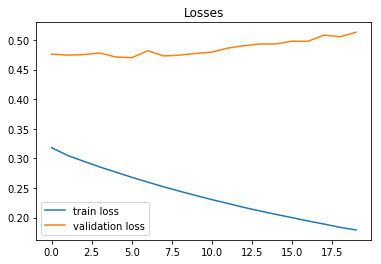

In [106]:
epochs_vals = range(0, epochs)
losses=history.history['loss']
val_losses=history.history['val_loss']
plt.title('Losses')
plt.plot(epochs_vals, losses, label='train loss')
plt.plot(epochs_vals, val_losses, label='validation loss')
plt.legend(loc='best')

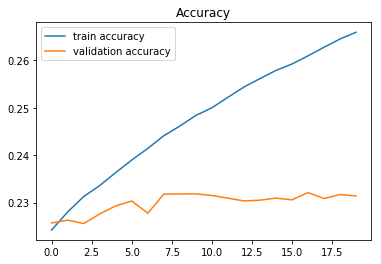

In [107]:
epochs_vals = range(0, epochs)
acc=history.history['acc']
val_acc=history.history['val_acc']
plt.title('Accuracy')
plt.plot(epochs_vals, acc, label='train accuracy')
plt.plot(epochs_vals, val_acc, label='validation accuracy')
plt.legend(loc='best')

## Evaluacija modela

Da bi se evaluirao ovako dobijeni model, potrebno je za rečenice skupa za testiranje generisati odgovarajuće prevode. 
Koraci koje ćemo pratiti će biti sledeći:

1) ulazna recenica prevede u odgovarajucu medjureprezentaciju tako sto se propusti kroz deo za kodiranje

2) na osnovu ovako dobijene reprezentacije i "start sequence" ulaza, pusta se da dekoder generise recenicu ciljnog jezika. Do kraja recenice se stize ili kada se generise "end sequence" karakter ili kada se dostigne maksimalna dozvoljena duzina. Proces generisanja se sastoji u pracenju pojedinacnih izlaza i njihovom prosledjivanju na ulazu sledecim iteracijama. 

In [73]:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token
# 3) Repeat with the current target token and current states

# Model koji odgovara delu za kodiranje
# nacin zadavanja je u skladu sa funkcionalnim API-jem Keras biblioteke pa se ocekuju ulazni i izlazni tenzor 
encoder_model = Model(encoder_inputs, encoder_states)


encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, 71)          0         
_________________________________________________________________
lstm_6 (LSTM)                [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Model koji odgovara delu za dekodiranje 

# ulazni tenzori
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# propustanje kroz lstm sloj
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# uvezivanje sa izlaznim slojem
decoder_outputs = decoder_dense(decoder_outputs)

# spajanje svih delova u model 
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 94)     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, None, 256),  359424      input_7[0][0]                    
                                                                 input_10[0][0]                   
          

In [81]:
# funkcije koje vracaju vrednosti karaktera za zadate numericke vrednosti 
reverse_input_char_index = dict( (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict( (i, char) for char, i in target_token_index.items())

In [82]:
print(reverse_input_char_index[45])
print(reverse_target_char_index[75])

a
Ç


In [83]:
def decode_sequence(input_seq):

    # zbog jednostavnosti je pretpostavka da je velicina paketica za testiranje 1 (batch_size =1)


    # ulazna sekvenca se propusta kroz deo za kodiranje
    states_value = encoder_model.predict(input_seq)

    # generise se vektor koji odgovara "start sequence" karakteru (\t)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    # postavlja se indikator kojim se proverava da li je generisana izlazna recenica ili ne
    stop_condition = False
    
    # izlazna recenica
    decoded_sentence = ''
    
    
    # sve dok se ne stigne do kraja recenice
    while not stop_condition:
        
        # prati se izlaz mreze za dekodiranje: prosledjuje joj se ulazni karakter i trenutno stanje mreze
        # u prvoj iteraciji trenutno stanje mreze odgovara izlazu dela za kodiranje
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # na osnovu izlazne raspodele verovatnoca, odredjuje se karakter sa najvecom verovatnocom 
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        
        # izdvojeni karakter se nadovezuje na izlaznu recenicu
        decoded_sentence += sampled_char

        
        # proverava se da li se stiglo do kraja recenice 
        # tj. da li se doslo do "end sequence" karaktera (znaka za novi red) ili maksimalne duzine izlaza
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

            
        # pripreme za nerednu iteraciju:
        
        # odredjuje se naredni ulazni karakter - izlaz prethodne iteracije 
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # azuriraju se stanja mreze 
        states_value = [h, c]

    return decoded_sentence

In [89]:
# test na jednom delu skupa za treniranje 
for seq_index in range(10, 40):
    
    # ulazna recenica - izdvajamo je iz skupa koji je koriscen za treniranje 
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    # njoj pridruzen prevod
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Humman translated sentence:', target_texts[seq_index])

-
Input sentence: Wait!
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Attendez !

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Poursuis.

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Continuez.

-
Input sentence: Go on.
Decoded sentence: Arrête de chent !

Humman translated sentence: 	Poursuivez.

-
Input sentence: I see.
Decoded sentence: Je suis prait de chante.

Humman translated sentence: 	Je comprends.

-
Input sentence: I try.
Decoded sentence: Je suis prait de chante.

Humman translated sentence: 	J'essaye.

-
Input sentence: I won!
Decoded sentence: Je suis prais de coure.

Humman translated sentence: 	J'ai gagné !

-
Input sentence: I won!
Decoded sentence: Je suis prais de coure.

Humman translated sentence: 	Je l'ai emporté !

-
Input sentence: Oh no!
Decoded sentence: Qui l'a parte ?

Humman translated sentence: 	Oh non !

-
Input sentence: Attack!
Decoded sentenc

Formalno, za evaluaciju sistema za prevođenje se koristi `BLUE` mera. Svakoj od prevedenih rečenica se pridružuje skor sa vrednošću iz intervala [0, 1], a zatim se dobijene vrednosti uproseče da bi se dobila konačna ocena sistema. Na nivou pojedinačnih rečenica skorovi se izračunavaju tako što se prati broj preklapanja n-grama u rečenici prevedenoj od strane sistema i rečenici prevedenoj od strane profesionalnih prevodilaca. Vrednosti za $n$ variraju od jezika do jezika, a obicno veće vrednosti odgovaraju "boljem" prevodu.  

## Zadaci za vežbu:

* Napraviti zaseban test skup na osnovu rečenica koje nisu iskorišćene i testirati model.
* Eksperimentisati sa modelima koji koriste GRU ćelije. 

## Za istarživanje:

* referentni rad [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)  
* rad koji je prethodio ovoj ideji [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078) 
* Razne primene generativnog karakterskog modela: http://karpathy.github.io/2015/05/21/rnn-effectiveness/